In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_obj_points(filename):
    points = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('v '):  # ligne de sommet
                parts = line.strip().split()
                x, y, z = map(float, parts[1:4])
                points.append([x, y, z])
    return np.array(points)

In [3]:
# load 3d object 
obj_points = read_obj_points('./assets/Wooden chair.obj')

In [4]:
def generate_K(f, k, l, q, cx, cy):
    """
    f : focale (zoom)
    k, l : échelle sur x et y
    q : skew (cisaillement)
    cx, cy : centre optique
    """
    K = np.array([
        [f*k, q,   cx],
        [0,   f*l, cy],
        [0,    0,   1]
    ])
    return K

In [5]:
def project_points(points_3d, K):
    points_2d = []
    for X, Y, Z in points_3d:
        p = np.array([X, Y, Z])
        proj = K @ (p / Z)
        points_2d.append(proj[:2])
    return np.array(points_2d)

In [6]:
def generate_binary_image(points_2d, width=400, height=400):
    img = np.zeros((height, width))
    for x, y in points_2d:
        xi, yi = int(x), int(y)
        if 0 <= xi < width and 0 <= yi < height:
            img[yi, xi] = 1
    return img

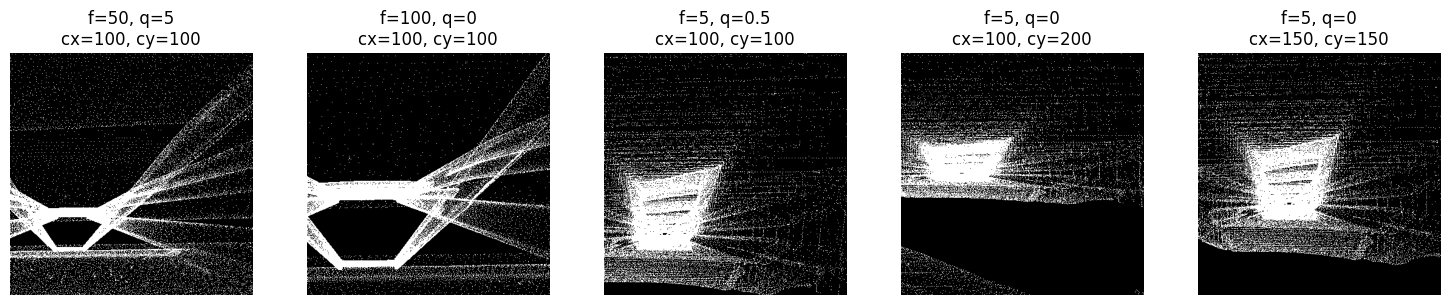

In [7]:
params_list = [
    (50, 1, 1, 5, 100, 100),   # skew important
    (100, 1, 1, 0, 100, 100),  # grande focale = zoom
    (5, 1, 1, 0.5, 100, 100),  # faible focale, léger skew
    (5, 1, 0.5, 0, 100, 200),  # échelle verticale différente, centre décalé
    (5, 1, 1, 0, 150, 150)     # centre déplacé
]

# --- Visualisation des effets ---
fig, axes = plt.subplots(1, len(params_list), figsize=(15, 3))

for i, (f, k, l, q, cx, cy) in enumerate(params_list):
    K = generate_K(f, k, l, q, cx, cy)
    pts_2d = project_points(obj_points, K)
    img = generate_binary_image(pts_2d)
    axes[i].imshow(img, cmap='gray', origin='lower')
    axes[i].set_title(f"f={f}, q={q}\ncx={cx}, cy={cy}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
alpha = 0
beta = np.radians(60) 
gama = np.radians(20)

In [9]:
rot_x_matrix = np.array([[1, 0, 0], [0, np.cos(alpha), -np.sin(alpha)], [0, np.sin(alpha), np.cos(alpha)]])
rot_y_matrix = np.array([[np.cos(beta), 0, np.sin(beta)], [0, 1, 0], [-np.sin(beta), 0, np.cos(beta)]])
rot_z_matrix = np.array([[np.cos(gama), -np.sin(gama), 0], [np.sin(gama), np.cos(gama), 0], [0, 0, 1]])


In [10]:
# Rotation matrix
R = rot_x_matrix @ rot_y_matrix @ rot_z_matrix

# Translation vector
t = np.array([[0], [0], [0]])

T = np.eye(4)          
T[:3, :3] = R          
T[:3, 3:] = t    
